# **Model and evaluation Notebook**

## Objectives

- Fit and evaluate a classification model to predict if a patient will suffer from heart disease or not.
- Fulfil business requirement 2.

## Inputs

* outputs/datasets/collection/heart.csv

## Outputs

* Test set (features and target)
* Data cleaning and Feature Engineering , and modeling pipeline
* Heatmap for confusion matrix report plot



---

# Set up the Working Directory

Define and confirm the working directory.

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspaces/heart-disease-analysis-and-prediction'

---

# Load data

In [2]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/heart.csv"))

# Separate predictors and target
X = df.drop(['target'], axis=1)
y = df['target']

print(X.shape)
X.head(3)

(1025, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3


## Split data int train and test set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'], axis=1),
    df['target'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (820, 13) (820,) 
* Test set: (205, 13) (205,)


In [4]:
# Remove duplicates from the test set
X_test = X_test.drop_duplicates(keep='first')
y_test = y_test.loc[X_test.index]

# Check the shape of the test set after removing duplicates
print("Test set shape after removing duplicates:", X_test.shape, y_test.shape)

Test set shape after removing duplicates: (161, 13) (161,)


In [5]:
# Remove duplicates from the train set
X_train = X_train.drop_duplicates(keep='first')
y_train = y_train.loc[X_train.index]

# Check the shape of the train set after removing duplicates
print("Train set shape after removing duplicates:", X_train.shape, y_train.shape)

Train set shape after removing duplicates: (301, 13) (301,)


# Finding the best combination of features

The following are the two combination of features study and found in previous notebooks:

- best_features = From ModelAndEvaluation notebook, found with feature importance.
- best_correlation_features = From FeatureSelection notebook, found with correlational study.

In [6]:
best_features = ['ca', 'cp', 'thal']
best_features

['ca', 'cp', 'thal']

In [7]:
best_correlation_features = ['ca', 'cp', 'exang', 'oldpeak', 'thalach', 'chol']
best_correlation_features

['ca', 'cp', 'exang', 'oldpeak', 'thalach', 'chol']

In [8]:
# Identify the difference between the two lists
difference = list(set(best_correlation_features) - set(best_features))
if difference:
    explanation = f"The original best features based on correlation were {', '.join(best_correlation_features)}."
    explanation += f" After additional analysis, the best features are {', '.join(best_features)}."
    explanation += f" The change made was replacing 'thalach' with 'thal'."
else:
    explanation = "The best features based on correlation match the updated best features."

print(explanation)

The original best features based on correlation were ca, cp, exang, oldpeak, thalach, chol. After additional analysis, the best features are ca, cp, thal. The change made was replacing 'thalach' with 'thal'.


In [10]:
features_selected = ['ca', 'cp', 'exang', 'oldpeak', 'thal', 'chol']

In [11]:
X_train_filtered = X_train.filter(features_selected)
X_test_filtered = X_test.filter(features_selected)

print(X_train_filtered.shape, y_train.shape, X_test_filtered.shape, y_test.shape)
X_train_filtered.head(3)

(301, 6) (301,) (161, 6) (161,)


,ca,cp,exang,oldpeak,thal,chol
315,2,3,0,0.8,2,244
204,1,2,0,0.0,2,278
363,3,2,0,0.0,2,246


# Test

In [18]:
from sklearn.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer

def pipeline_transformation():
  pipeline_base = Pipeline([
         ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['ca', 'cp', 'exang', 'oldpeak', 'thal', 'chol']) )
  ])

  return pipeline_base

pipeline_transformation()

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['ca', 'cp', 'exang',
                                                  'oldpeak', 'thal',
                                                  'chol']))])

In [16]:
from sklearn.preprocessing import StandardScaler # Feat Scaling
from sklearn.feature_selection import SelectFromModel # Feature Selection

def pipeline_clf(model):
  pipeline_base = Pipeline([
       ("scaler",StandardScaler() ),
        ("feature_selection", SelectFromModel(model)),
        ("model", model),
  ])

  return pipeline_base

In [14]:
from sklearn.model_selection import GridSearchCV
import numpy as np


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = pipeline_clf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In [12]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [19]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train_filtered, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [20]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,XGBClassifier,0.592593,0.722222,0.857143,0.100222
3,GradientBoostingClassifier,0.62963,0.700529,0.75,0.04378
4,ExtraTreesClassifier,0.592593,0.671429,0.777778,0.076914
2,RandomForestClassifier,0.518519,0.663228,0.785714,0.110358
1,DecisionTreeClassifier,0.555556,0.627778,0.703704,0.057861
5,AdaBoostClassifier,0.444444,0.525397,0.592593,0.052687


In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier


models_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}


params_search = {
    "XGBClassifier": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
    },
    "GradientBoostingClassifier": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
    },
    "ExtraTreesClassifier": {
        "model__n_estimators": [20],
        "model__max_depth": [5],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1],
    }
}


In [22]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train_filtered, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(5)

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__min_samples_leaf,model__min_samples_split
0,XGBClassifier,0.818182,0.89053,0.9375,0.040663,0.01,3,50,NaN,NaN
8,XGBClassifier,0.818182,0.89053,0.9375,0.040663,0.01,5,200,NaN,NaN
2,XGBClassifier,0.818182,0.89053,0.9375,0.040663,0.01,3,200,NaN,NaN
3,XGBClassifier,0.818182,0.89053,0.9375,0.040663,0.01,4,50,NaN,NaN
4,XGBClassifier,0.818182,0.89053,0.9375,0.040663,0.01,4,100,NaN,NaN


In [24]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

In [25]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 50}

In [26]:
best_classification_pipeline = grid_search_pipelines[best_model].best_estimator_
best_classification_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         gpu_id=None,
                                                         grow_policy=None,
                                                         import...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

# Reaxamine performance of the pipeline

Loading pipeline from " ModelAndEvaluation notebook " section "We create a new pipeline, using the best model and the best hyperparameters from the research above."

We know that the following pipeline has the best model and the best hyperparameters

In [11]:
from xgboost import XGBClassifier
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def xgbclassifier_pipeline():
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 50
    }

    model = XGBClassifier(**hyperparameters)

    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['ca', 'cp', 'exang', 'oldpeak', 'thal', 'chol'])),
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(estimator=model)),
        ('model', model)
    ])

    return pipeline_base

# Create the XGBoost pipeline with hyperparameters
xgb_pipeline = xgbclassifier_pipeline()
xgb_pipeline.fit(X_train_filtered, y_train)

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['ca', 'cp', 'exang',
                                                  'oldpeak', 'thal', 'chol'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train_selected, y_train, X_test_filtered, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train_filtered, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test_filtered, y_test, pipeline, label_map)

In [13]:
print(classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83        75
           1       0.82      0.93      0.87        86

    accuracy                           0.85       161
   macro avg       0.86      0.85      0.85       161
weighted avg       0.86      0.85      0.85       161



Heatmap for classification report

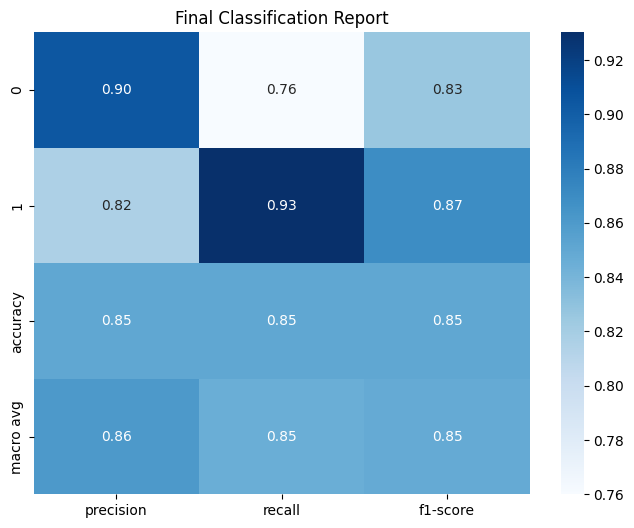

In [14]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
report = classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Final Classification Report')

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'
# Define the filename for this plot
plot_filename_classification_report_1 = f'{file_path}/classification_report_3.png'

plt.show()

Combination of features that finally meet the business requirements metrics with a performance of:

- **Accuracy of 0.85**
- **Precision on class 0 of 0.90**
- Precision on class 1 of 0.82
- **Recall of class 1 of 0.93**
- Recall of class 0 of 0.76

Developer chose this as the best combination of features .

---

# Save and push file to repo

We will generate the following files:

- Train set
- Test set
- Data cleaning and Feature Engineering , and modeling pipeline
- Heatmap plot for confusion matrix report

In [ ]:
import os

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train = X_train_filtered
X_test = X_test_filtered

X_train.head(3)

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test set

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Save pipeline

In [ ]:
xgbclassifier_pipeline = xgb_pipeline
xgbclassifier_pipeline

In [ ]:
import joblib

joblib.dump(value=xgbclassifier_pipeline,
            filename=f"{file_path}/xgbclassifier_pipeline.pkl")

## Save heatmap report on performance

In [ ]:
# Generate classification report
report = classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 1')

# Save the plot to the specified filename
plt.savefig(plot_filename_classification_report_1, bbox_inches='tight')

# Display the saved plot
plt.show()